Initial -> X:(10, 2)  y:(10,)  y∈[-0.0656, 0.6112]
Week 1 added -> x: [0.728919 0.008403]  y: 0.4418679227641883
Week 2 added -> x: [0.684763 0.992806]  y: 0.6397916079538416


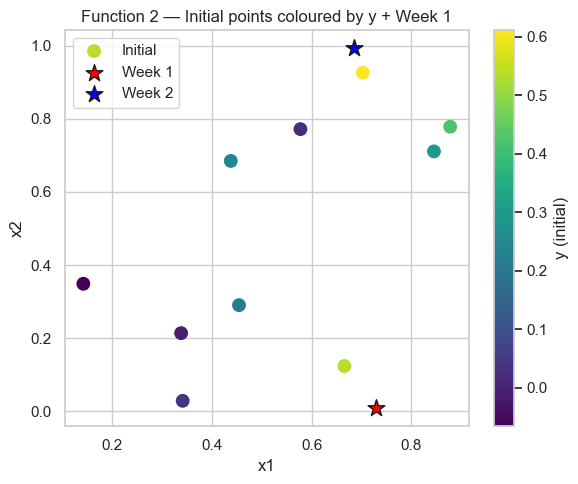

In [3]:
# --- Imports base (si no están ya) ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "initial_data" / "function_2"
assert DATA_DIR.exists(), f"No se encontró {DATA_DIR}"

# --- 1. Load data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

print(f"Initial -> X:{X.shape}  y:{y.shape}  y∈[{y.min():.4f}, {y.max():.4f}]")

# === Semana 1: punto enviado y output recibido  ===
w1_input  = np.array([0.728919, 0.008403], dtype=float)
w1_output = float(0.4418679227641883)

# === Semana 2: punto enviado y output recibido ===
w2_input  = np.array([0.684763, 0.992806], dtype=float)
w2_output =  float(0.6397916079538416)

# Copia "antes de W1" para colorear y para TR anclada en iniciales
X_prev, y_prev = X.copy(), y.copy()

# Actualiza dataset con W1
X = np.vstack([X, w1_input, w2_input])
y = np.append(y, [w1_output, w2_output])

print("Week 1 added -> x:", w1_input, " y:", w1_output)
print("Week 2 added -> x:", w2_input, " y:", w2_output)

# --- Scatter inicial + W1 marcado ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X_prev[:,0], X_prev[:,1], c=y_prev, cmap='viridis', s=80, label="Initial")
plt.colorbar(sc, label='y (initial)')
plt.scatter(w1_input[0], w1_input[1], c='red', edgecolors='k', s=160, marker='*', label='Week 1')
plt.scatter(w2_input[0], w2_input[1], c='blue', edgecolors='k', s=160, marker='*', label='Week 2')
plt.title('Function 2 — Initial points coloured by y + Week 1')
plt.xlabel('x1'); plt.ylabel('x2'); plt.legend(loc='best'); plt.tight_layout(); plt.show()

In [5]:
# === F2 – Week 3 suggestion (EI with xi=0.03, TR 80/20) ===
import numpy as np
from scipy.stats import norm, qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C

# 1) GP (ARD + ruido)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3,0.3], nu=2.5,
                                      length_scale_bounds=(1e-2, 3.0)) \
         + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
gp.fit(X, y)
print("Kernel:", gp.kernel_)

# 2) Candidatos (80% TR alrededor de W2, 20% global)
w2 = np.array([0.684763, 0.992806])      # tu mejor actual
lo, hi = np.array([0.0,0.0]), np.array([1.0,1.0])
L = 0.35                                 # ancho relativo de TR
lb_tr = np.clip(w2 - 0.5*L*(hi-lo), 0, 1)
ub_tr = np.clip(w2 + 0.5*L*(hi-lo), 0, 1)

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub-lb)

C_tr = lhs(lb_tr, ub_tr, 24000, seed=3031)
C_gl = lhs(lo,    hi,    6000,  seed=3032)
Cands = np.vstack([C_tr, C_gl])

# 3) EI con xi más bajo (explotación moderada)
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)
y_best = y.max()
xi = 0.03   # <= si quieres aún más explotación, usa 0.02
Z = (mu - y_best - xi) / sigma
ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# 4) Anti-borde y anti-duplicado
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

order = np.argsort(-ei_masked)
x_next = None
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.02):
        x_next = cand; break

print("Suggested next (F2, W3):", x_next)
print("Submission:")
print(f"{x_next[0]:.6f} - {x_next[1]:.6f}")

Kernel: 0.967**2 * Matern(length_scale=[0.0695, 3], nu=2.5) + WhiteKernel(noise_level=0.00793)
Suggested next (F2, W3): [0.96681076 0.86266543]
Submission:
0.966811 - 0.862665


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [6]:
import numpy as np
cand = np.array([0.96681076, 0.86266543])
def within_unit(c): return np.all((c>=0)&(c<=1))
def too_close_Linf(c, X, tol=0.02): return np.any(np.max(np.abs(X-c), axis=1) < tol)

print("Within [0,1]?", within_unit(cand))                 # True esperado
print("Near-duplicate (L_inf<0.02)?", too_close_Linf(cand, X, 0.02))  # False esperado

Within [0,1]? True
Near-duplicate (L_inf<0.02)? False


Mini-bitácora (2–3 líneas)
	•	Method: GP (Matern ARD, noise≈0.008) + EI (xi=0.03), TR 80/20.
	•	Decision: Refinar cerca de W2 moviendo sobre x1 (dimensión más sensible; length_scale≈0.07), manteniendo x2 en zona alta.
	•	Next step (según resultado): Si mejora, baja a xi=0.02; si no mejora, sube a xi=0.05 y abre TR.

Campo
Contenido sugerido
Function
2
Method
Gaussian Process (Matern ν = 1.5 + WhiteKernel)
Acquisition
Expected Improvement (ξ = 0.05)
Focus
Exploración moderada en zona de alta incertidumbre (borde x₂ ≈ 0)
Submission
0.728919 - 0.008403
Reasoning
EI sugiere área poco muestreada con potencial de mejora. Esperar confirmación en próxima semana para refinar el modelo.
